In [1]:
import code_tokenize
import re
def my_tokenizer(text):
    text = re.sub(r'\b\d+\.\d+\b', lambda x: str(float(x.group())), text)
    tokens = code_tokenize.tokenize(text, lang="c", syntax_error="ignore")
    tokens_list = [str(x) for x in tokens]
    return tokens_list

In [2]:
# tokenize the data that can be used by embeddings
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import pickle


tokenizer_path = "F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//tokenizer.pkl"
retrain = False
if os.path.exists(tokenizer_path) and not retrain:
    print("[INFO] Loading saved tokenizer")
    with open(tokenizer_path, "rb") as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
else:
    t0 = time()
    print("[INFO] fitting tokenizer on TRAIN data...")
    tokenizer = Tokenizer(lower=False, analyzer = my_tokenizer)  # used in the research paper
    tokenizer.fit_on_texts(X_train.apply(lambda x: np.str_(x)))
    # save the tokenizer for future use
    with open(tokenizer_path, "wb") as tokenizer_file:
        pickle.dump(tokenizer, tokenizer_file, protocol=pickle.HIGHEST_PROTOCOL)
        # pickle.HIGHEST_PROTOCOL is highest protocol version available
    print(f"time taken to fit and save the tokenizer: {time()-t0} s")   

[INFO] Loading saved tokenizer


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score,ConfusionMatrixDisplay
import pandas as pd


os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack



import pickle
from gensim.models import Word2Vec

def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test

def load_data():
    df = pd.read_csv('F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//CSVs//preprocessed_df_100k.csv')
    df_target_0 = df[df['target'] == 0].head(35000)
    df_target_1 = df[df['target'] == 1]
    
    df_filtered = pd.concat([df_target_0, df_target_1], ignore_index=True)
    
    X_train, X_test, y_train, y_test = train_test_split(
        df_filtered['func'],
        df_filtered['target'],
        test_size=0.1,
        random_state=42,
        stratify=df_filtered['target']
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test





PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


C:\Users\shaur\miniconda3\envs\tf\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


> Loaded F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec 3//w2v 30\BILSTM_w2v_150.keras
> Loaded F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec 3//w2v 30\GRU_w2v_150.keras
> Loaded F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec 3//w2v 30\LSTM_w2v_150.keras
Sample of stackX before reshaping:
[[5.000e-04 0.000e+00 0.000e+00]
 [9.995e-01 1.000e+00 1.000e+00]]
[[1. 1. 1.]
 [0. 0. 0.]]
[[9.990e-01 1.000e+00 9.998e-01]
 [1.000e-03 0.000e+00 2.000e-04]]
Shape of stackX before reshaping: (43695, 2, 3)
Shape of stackX after reshaping: (43695, 6)
Sample of stackX after reshaping:
[5.000e-04 0.000e+00 0.000e+00 9.995e-01 1.000e+00 1.000e+00]
[1. 1. 1. 0. 0. 0.]
[9.990e-01 1.000e+00 9.998e-01 1.000e-03 0.000e+00 2.000e-04]
Epoch 1/50
615/615 [==============================] - 2s 2ms/step - loss: 0.1359 - accuracy: 0.9589 - val_loss: 0.0960 - val_accuracy: 0.9664
Epoch 2/50
615/

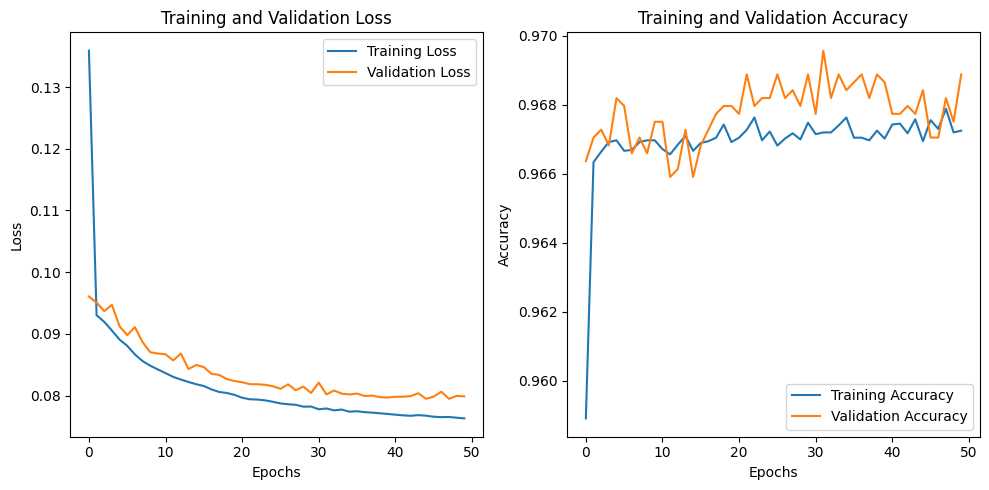

Sample of stackX before reshaping:
[[1.     0.9907 0.9951]
 [0.     0.0093 0.0049]]
[[1.000e+00 9.999e-01 1.000e+00]
 [0.000e+00 1.000e-04 0.000e+00]]
[[1. 1. 1.]
 [0. 0. 0.]]
Shape of stackX before reshaping: (5395, 2, 3)
Shape of stackX after reshaping: (5395, 6)
Sample of stackX after reshaping:
[1.     0.9907 0.9951 0.     0.0093 0.0049]
[1.000e+00 9.999e-01 1.000e+00 0.000e+00 1.000e-04 0.000e+00]
[1. 1. 1. 0. 0. 0.]
169/169 [==============================] - 0s 464us/step


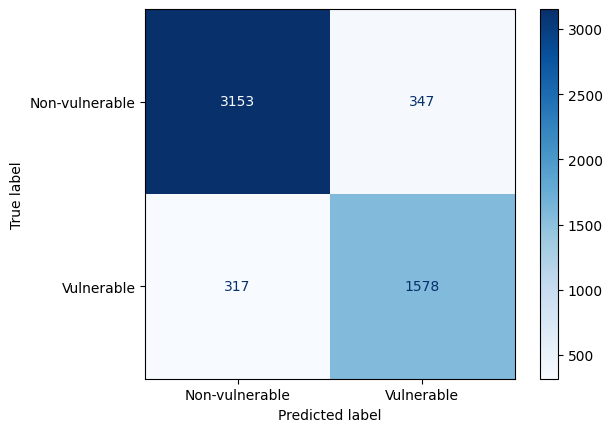

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3500
           1       0.82      0.83      0.83      1895

    accuracy                           0.88      5395
   macro avg       0.86      0.87      0.87      5395
weighted avg       0.88      0.88      0.88      5395

Confusion Matrix:
[[3153  347]
 [ 317 1578]]
False Positive Rate (FPR): 0.09914285714285714
False Negative Rate (FNR): 0.16728232189973616
Sample of y_test:
33855    0
12808    0
26788    0
4495     0
13575    0
Name: target, dtype: int64
Sample of yhat:
[[0]
 [0]
 [0]
 [0]
 [0]]
Stacked Test Accuracy: 0.877


In [4]:
import os
from keras.models import load_model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import sys
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt

import os

def load_all_models(i=0):
    all_models = list()

    folder_path = 'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec 3//w2v 30'
    if i == 0:
        model_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]
    else:
        model_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]
    
    for filename in model_files:
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)
        all_models.append(model)
        print(f'> Loaded {model_path}')

    return all_models


def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))
    
    print("Sample of stackX before reshaping:")
    for i in range(min(3, stackX.shape[0])):
        print(np.round(stackX[i], decimals=4))
        
    # flatten predictions to [rows, members x probabilities]
    print("Shape of stackX before reshaping:", stackX.shape)
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    print("Shape of stackX after reshaping:", stackX.shape)
    
    print("Sample of stackX after reshaping:")
    for i in range(min(3, stackX.shape[0])):
        print(np.round(stackX[i], decimals=4))

    return stackX



def fit_stacked_model(members, inputX, inputy, validation_split=0.1):
    stackedX = stacked_dataset(members, inputX)
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(stackedX.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(stackedX, inputy, epochs=50, batch_size=64, verbose=1, validation_split=validation_split)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model




# def evaluate_model(X_test_padded, y_test, model):
#     stackedX = stacked_dataset(members, inputX)
#     y_pred_prob = model.predict(X_test_padded)
#     y_pred = (y_pred_prob > 0.5).astype(int)
#     report = classification_report(y_test, y_pred)
#     confusion = confusion_matrix(y_test, y_pred)
#     class_names = {0: "Non-vulnerable", 1: "Vulnerable"}  # Example mapping for binary classes
#     labels = list(class_names.values())

#     disp = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = labels)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.show()
#     print(report)
#     print("Confusion Matrix:")
#     print(confusion)
    
def stacked_prediction(members, model, inputX, y_test, threshold=0.5):
    stackedX = stacked_dataset(members, inputX)
    yhat = model.predict(stackedX)
    yhat_binary = (yhat > threshold).astype(int)
    report = classification_report(y_test, yhat_binary)

    confusion = confusion_matrix(y_test, yhat_binary)
    class_names = {0: "Non-vulnerable", 1: "Vulnerable"}  # Example mapping for binary classes
    labels = list(class_names.values())

    tn, fp, fn, tp = confusion.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(report)
    print("Confusion Matrix:")
    print(confusion)
    print("False Positive Rate (FPR):", fpr)
    print("False Negative Rate (FNR):", fnr)
    
    return yhat_binary

X_train, X_val, X_test, y_train, y_val, y_test = load_data()
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# y_test = to_categorical(y_test)

X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)

import itertools

members = load_all_models(0)
# for model in members:
#    _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
#    print('Model Accuracy: %.3f' % acc

# fit stacked model using the ensemble
model = fit_stacked_model(members, X_train_padded, y_train)

# evaluate model on test set
yhat = stacked_prediction(members, model, test_padded, y_test)
print("Sample of y_test:")
print(y_test[:5])  # Print the first 5 elements of y_test

print("Sample of yhat:")
print(yhat[:5])  # Print the first 5 elements of yhat


acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)
# evaluate_model(X_test_padded, y_test, model)
